In [65]:
import numpy as np
import pandas as pd
import xgboost
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


In [128]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("model_v2.csv")
computer = [col for col in df.columns if "computer" in col.lower()]
df = df.drop(computer, axis=1)
df.columns = [c.replace("[", "").replace("]", "").replace("<","") for c in df.columns]
df.columns = [re.sub(r'[^a-zA-Z0-9]', '', s) for s in df.columns]
print([col for col in df.columns if "computer" in col.lower()])
# print(len(set(df.columns)))
# print(len(df.columns))

# df = df.set_index("Name")
deaths = [col for col in df.columns if "covid" in col.lower()]
tot_pop = [col for col in df.columns if "total" in col.lower()][0]
y = df[deaths[0]]
y_cases = df[deaths[1]]
# Normalized y
# y_lab = y[labels[0]]
# df = df[df[labels[11]].isna() == False]
df = df[y.isna() == False]
y_lab = y[y.isna() == False]
x = df.drop(deaths, axis=1)
# x = x.drop(tot_pop, axis=1)
bad_col = [c for c in x.columns if x[c].isna().sum() > 10]
x = x.drop(bad_col, axis=1)
print(y_lab.shape)
print(x.shape)

[]
(3220,)
(3220, 164)


In [101]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220 entries, 0 to 3219
Data columns (total 168 columns):
 #    Column                                                                                                                      Dtype  
---   ------                                                                                                                      -----  
 0    TotalPopulation2020Estimated                                                                                                float64
 1    Age5to9years2020Estimated                                                                                                   float64
 2    Age10to14years2020Estimated                                                                                                 float64
 3    Age15to17years2020Estimated                                                                                                 float64
 4    Age18and19years2020Estimated                              

In [129]:
# X_T, X_test, y_T, y_test = train_test_split(x, y_lab, test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

(array([1.085e+03, 9.970e+02, 3.420e+02, 1.070e+02, 2.600e+01, 1.000e+01,
        5.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([0.        , 0.00084975, 0.0016995 , 0.00254925, 0.003399  ,
        0.00424874, 0.00509849, 0.00594824, 0.00679799, 0.00764774,
        0.00849749]),
 <BarContainer object of 10 artists>)

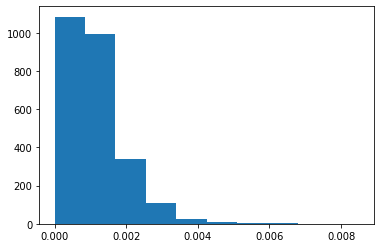

In [103]:
plt.hist(y_train)

In [130]:
lm = LinearRegression().fit(X_train, y_train)
y_pred = lm.predict(X_test)
y_pred_train = lm.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

Root Mean squared error: 0.000739721
Root Mean squared error train: 0.000623242
Coefficient of determination: 0.30
Coefficient of determination train: 0.45


In [112]:
parameters = {
    'alphas': [[0.1], [0.2], [1.0], [2.0]],
    'max_iter': [10000, 100000],
    'l1_ratio': [0.25, 0.3, 0.35, 0.4, 0.45]
}

# Initialize the linear regression model with L1 and L2 regularization (Elastic Net)
enet_model = ElasticNetCV()

# Use GridSearchCV to find the best hyperparameters for the linear regression model
clf = GridSearchCV(enet_model, parameters, cv=4, scoring='neg_root_mean_squared_error', n_jobs=8)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

# Calculate the mean squared error
# mse = mean_squared_error(y_test, y_pred)
# mse_train = mean_squared_error(y_train, y_pred_train)

# # Calculate the R^2 statistic
# r2 = r2_score(y_test, y_pred)
# r2_train = r2_score(y_train, y_pred_train)

# Print the mean squared error and the R^2 statistic
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("ROot Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

{'alphas': [0.1], 'l1_ratio': 0.35, 'max_iter': 10000}
Root Mean squared error: 0.000883634
ROot Mean squared error train: 0.000836613
Coefficient of determination: 0.0026
Coefficient of determination train: 0.0038


In [113]:
def rmse(x, y):
    return mean_squared_error(x, y, squared=False)
xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=3, learning_rate=0.01, tree_method="hist", eval_metric=rmse)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

Root Mean squared error: 0.000681810
Root Mean squared error train: 0.000532480
Coefficient of determination: 0.41
Coefficient of determination train: 0.60


In [114]:
svm = SVR(C=0.4, epsilon=0.3, kernel="sigmoid")
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
y_pred_train = svm.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

Root Mean squared error: 0.003228074
Root Mean squared error train: 0.003235065
Coefficient of determination: -12.31
Coefficient of determination train: -13.90


In [131]:
# Create a LightGBM dataset for training
train_data = lgb.Dataset(X_train, label=y_train)

# Create a LightGBM dataset for validation
val_data = lgb.Dataset(X_test, label=y_test)

# Define the parameters for LightGBM
parameters = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'verbose': 1
}

# Train the model
model = lgb.train(parameters, train_data, valid_sets=val_data, num_boost_round=500, early_stopping_rounds=10)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
# The mean squared error
print("Root Mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root Mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.2f" % r2_score(y_train, y_pred_train))

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28167
[LightGBM] [Info] Number of data points in the train set: 2576, number of used features: 151
[LightGBM] [Info] Start training from score 0.001124
[1]	valid_0's rmse: 0.000879453
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 0.000872243
[3]	valid_0's rmse: 0.000865222
[4]	valid_0's rmse: 0.000857415
[5]	valid_0's rmse: 0.00085115
[6]	valid_0's rmse: 0.000846762
[7]	valid_0's rmse: 0.000843135
[8]	valid_0's rmse: 0.000837201
[9]	valid_0's rmse: 0.000834748
[10]	valid_0's rmse: 0.000830064
[11]	valid_0's rmse: 0.000827237
[12]	valid_0's rmse: 0.000823627
[13]	valid_0's rmse: 0.000816925
[14]	valid_0's rmse: 0.000814815
[15]	valid_0's rmse: 0.00080927
[16]	valid_0's rmse: 0.000806364
[17]	valid_0's rmse: 0.00080505
[18]	valid_0's rmse: 0.000802271
[19]	valid_

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values, max_display=20)

In [117]:
# Create a LightGBM dataset for training
train_data = lgb.Dataset(X_train, label=y_train)

# Create a LightGBM dataset for validation
val_data = lgb.Dataset(X_test, label=y_test)

# Define the parameters for LightGBM
parameters = {
    'num_leaves': [10, 30, 50],
    'learning_rate': [0.01, 0.05],
    'feature_fraction': [0.8, 0.9],
    'bagging_freq': [5, 7]
}
model = lgb.LGBMRegressor(objective="regression", metric="rmse")

clf = GridSearchCV(model, parameters, scoring='r2', cv=3)

clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 w

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 w

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
{'bagging_freq': 5, 'feature_fraction': 0.8, 'learning_rate': 0.05, 'num_leaves': 30}
Root mean squared error: 0.000654085
Root mean squared error train: 0.000375406
Coefficient of determination: 0.4535
Coefficient of determination train: 0.7994


In [118]:
xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=10, tree_method="hist")

# Set up the parameters for the XGBoost model
parameters = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000]
}

clf = GridSearchCV(xgb, parameters, scoring='explained_variance', cv=3)

clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}
Root mean squared error: 0.000668986
Root mean squared error train: 0.000375406
Coefficient of determination: 0.4283
Coefficient of determination train: 0.7994


In [84]:
rdf = RandomForestRegressor()

# Set up the parameters for the XGBoost model
parameters = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 500, 1000]
}

clf = GridSearchCV(rdf, parameters, scoring='r2', cv=3)

clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print(clf.best_params_)

y_pred = clf.predict(X_test)

y_train_pred = clf.predict(X_train)
# Calculate the mean squared error

print("Root mean squared error: %.9f" % mean_squared_error(y_test, y_pred, squared=False))
print("Root mean squared error train: %.9f" % mean_squared_error(y_train, y_pred_train, squared=False))

print("Coefficient of determination: %.4f" % r2_score(y_test, y_pred))
print("Coefficient of determination train: %.4f" % r2_score(y_train, y_pred_train))

{'max_depth': 7, 'n_estimators': 100}
Root mean squared error: 0.000792870
Root mean squared error train: 0.000338043
Coefficient of determination: 0.1970
Coefficient of determination train: 0.8374
